#Задание

1. найти в открытых источниках 2 временных ряда длиной 500-1000 измерений (про финансовые процессы) разного вида:
  * с явными периодами (например, потребление энергии);
  * с броуновским движением (как биржевые котировки).
2. реализовать (можно найти готовый, только хороший) алгоритм расчёта корреляционной размерности (и размерности вложения).
3. средствами tSNE красиво изобразить фазовую траекторию системы, породившей каждый из рядов.
4. сделать выводы о характере системы на основании исследованного.

Пока так, подробности обсудим при встрече. Там же дам подсказки и указания.

ссылка на ноут в колабе: https://colab.research.google.com/drive/1a_QxRmZqdZAbmiBREklYIPeEWFlhJ1Ns#scrollTo=jktrFF5ocbNK

# Импорт библиотек

In [115]:
pip install yfinance

In [116]:
pip install -U giotto-tda

In [117]:
import yfinance as yf
from gtda.time_series import embedding, TakensEmbedding
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px

# Загрузка данных

In [118]:
# Берем волатильный актив (биткоин с тикером BTC) и абсолютно неволатильный актив (фиатная валюта USDT - цифровой доллар, курс которого стремится к цене бумажного доллара)
# Биржевые котировки берутся на равном промежутке времени и по отношению к доллару (USD)

symbols = ['BTC-USD', 'USDT-USD']
data = pd.DataFrame(yf.download(symbols, '2022-10-01', '2022-11-17', interval='1h'))
data = data['Close']
data

[*********************100%%**********************]  2 of 2 completed


,BTC-USD,USDT-USD
Datetime,,
2022-10-01 00:00:00+00:00,19400.000000,1.000052
2022-10-01 01:00:00+00:00,19425.039062,1.000051
2022-10-01 02:00:00+00:00,19422.853516,1.000062
2022-10-01 03:00:00+00:00,19412.548828,1.000038
2022-10-01 04:00:00+00:00,19404.400391,0.999988
...,...,...
2022-11-16 19:00:00+00:00,16554.962891,0.999194
2022-11-16 20:00:00+00:00,16580.814453,0.999221
2022-11-16 21:00:00+00:00,16551.392578,0.999201


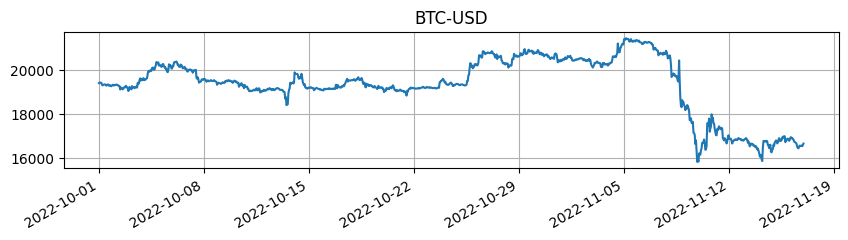

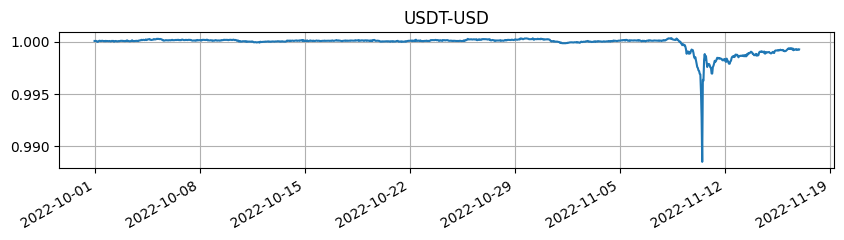

In [119]:
for i in symbols:
  plt.figure(figsize=(10,2))
  plt.title(i)
  plt.plot(data[i])
  plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
  plt.gcf().autofmt_xdate()
  plt.grid()
  plt.show();

# Вычисляем размерность вложения и визуализируем фазовую траекторию системы

Ряд BTC-USD:
Размерность вложения (embedding): 7
time_delay: 93


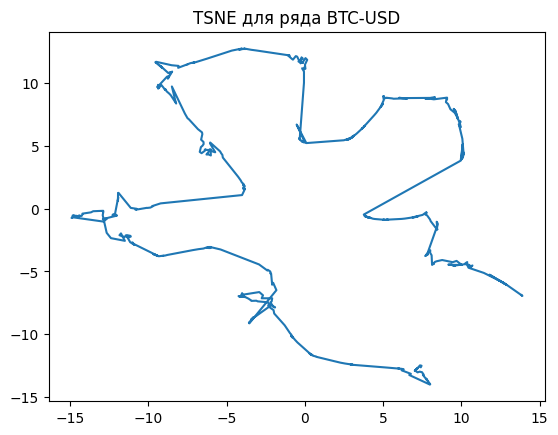

Ряд USDT-USD:
Размерность вложения (embedding): 7
time_delay: 100


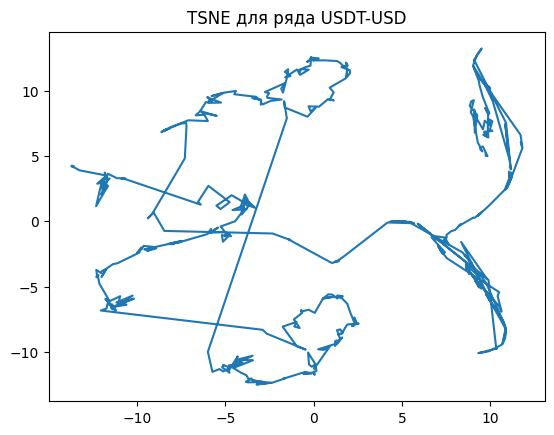

In [130]:
# Для двумерного пространства, n_components=2

for i in symbols:
    optimal_time_delay, optimal_embedding_dimension = embedding.takens_embedding_optimal_parameters(data[i], 100, 10)
    print(f'Ряд {i}:')
    print(f'Размерность вложения (embedding): {optimal_embedding_dimension}')
    print(f'time_delay: {optimal_time_delay}')

    phase = TakensEmbedding(optimal_time_delay, optimal_embedding_dimension).fit_transform(data[i].values.reshape(1, -1))[0]
    tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
    results = tsne.fit_transform(phase)

    # Визуализация в двумерном пространстве
    plt.plot(results[:, 0], results[:, 1])
    plt.title(f'TSNE для ряда {i}')
    plt.show()

In [121]:
# Для трехмерного пространства, n_components=3

for i in symbols:
    optimal_time_delay, optimal_embedding_dimension = embedding.takens_embedding_optimal_parameters(data[i], 100, 10, stride=1)
    phase = TakensEmbedding(optimal_time_delay, optimal_embedding_dimension).fit_transform(data[i].values.reshape(1, -1))[0]
    tsne = TSNE(n_components=3, perplexity=30, n_iter=300)
    results = tsne.fit_transform(phase)

    fig = px.line_3d(pd.DataFrame(results, columns=['x', 'y', 'z']), x="x", y="y", z="z")
    fig.update_layout(title=f'TSNE для ряда {i}')
    fig.show()

# Энтропия Колмогорова-Синая

In [122]:
from scipy.stats import entropy

In [123]:
def KSEntr(data):
    l=len(data)
    e=[]
    for i in range(1, l//2+1):
        b= l//i
        hist,bins=np.histogram(data, bins=b)
        e.append(entropy(hist/l,  base=2))
    return max(e)

In [141]:
for i in symbols:
  print(f'Ряд {i}, энтропия: {KSEntr(data[i])}')

Ряд BTC-USD, энтропия: 8.570496485547128
Ряд USDT-USD, энтропия: 5.910617845328692


Энтропия ряда волатильного актива 'BTC-USD' принимает большее значение, что указывает на превосходящую сложность и хаотичность системы, где информация о начальном состоянии быстро теряется.

Энтропия ряда неволатильного актива 'USDT-USD' принимает меньшее значение, что указывает на более предсказуемую систему, где информация сохраняется дольше.